In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import syft as sy
from syft.frameworks.torch.federated import FederatedDataset, FederatedDataLoader, BaseDataset
from torchvision import transforms
from torchvision import datasets

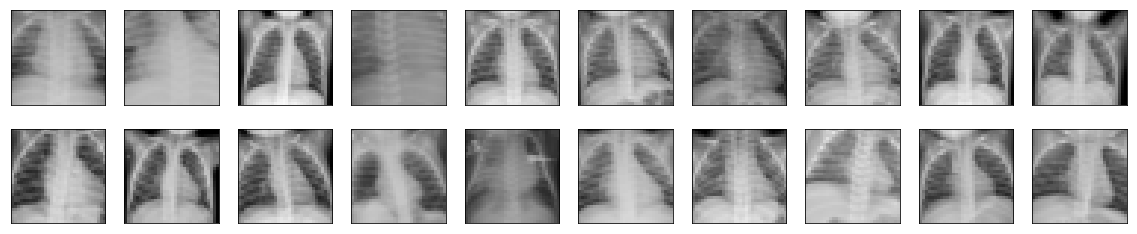

In [2]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [3]:
hook = sy.TorchHook(torch)

In [4]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

In [5]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   'valid': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/val', 
                                                                             transform=image_transforms['valid']),
                                                        batch_size=128, shuffle=True), 
                   'test': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/test', 
                                                                            transform=image_transforms['test']),
                                                        batch_size=128, shuffle=True)}

In [6]:
import math
import logging

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)
def dataset_federate(dataset, workers):
    """
    Add a method to easily transform a torch.Dataset or a sy.BaseDataset
    into a sy.FederatedDataset. The dataset given is split in len(workers)
    part and sent to each workers
    """
    logger.info("Scanning and sending data to {}...".format(", ".join([w.id for w in workers])))

    # take ceil to have exactly len(workers) sets after splitting
    data_size = math.ceil(len(dataset) / len(workers))

    # Fix for old versions of torchvision
#     if not hasattr(dataset, "data"):
#         if hasattr(dataset, "train_data"):
#             dataset.data = dataset.train_data
#         elif hasattr(dataset, "test_data"):
#             dataset.data = dataset.test_data
#         else:
#             raise AttributeError("Could not find inputs in dataset")
#     if not hasattr(dataset, "targets"):
#         if hasattr(dataset, "train_labels"):
#             dataset.targets = dataset.train_labels
#         elif hasattr(dataset, "test_labels"):
#             dataset.targets = dataset.test_labels
#         else:
#             raise AttributeError("Could not find targets in dataset")

    datasets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=data_size, drop_last=True)
    for dataset_idx, (data, targets) in enumerate(data_loader):
        worker = workers[dataset_idx % len(workers)]
        logger.debug("Sending data to worker %s", worker.id)
        data = data.send(worker)
        targets = targets.send(worker)
        datasets.append(BaseDataset(data, targets))  # .send(worker)

    logger.debug("Done!")
    return FederatedDataset(datasets)

datasets.ImageFolder.federate = dataset_federate

In [7]:
federated_train_loader = sy.FederatedDataLoader(datasets.ImageFolder('chest_xray/train', 
                                                transform=image_transforms['train']).federate((bob, alice)),
                                                batch_size=128, shuffle=True)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(140450, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [9]:
model = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

In [13]:
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location)
        output = model(data)
        data, target = data.to('cpu'), target.to('cpu')
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % 30 == 0:
            loss = loss.get() 
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['test']):
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Testing data accuracy: {:.0%}'.format(total_correct/total))
    if total_correct/total > 0.5:
        torch.save(model.state_dict(), 'pt_federated/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Train Epoch: 0 Loss: 1.014269
Epoch:  0
Loss:  1.3379448652267456
Loss:  1.5028040409088135
Loss:  1.072692632675171
Loss:  1.4523496627807617
Loss:  1.0441906452178955
Testing data accuracy: 69%
Train Epoch: 1 Loss: 0.832934
Epoch:  1
Loss:  1.5529415607452393
Loss:  1.2697645425796509
Loss:  1.246140718460083
Loss:  1.2631670236587524
Loss:  1.1972318887710571
Testing data accuracy: 69%
Train Epoch: 2 Loss: 0.879972
Epoch:  2
Loss:  1.3035866022109985
Loss:  1.3737974166870117
Loss:  1.2598196268081665
Loss:  1.2221274375915527
Loss:  1.4900367259979248
Testing data accuracy: 69%
Train Epoch: 3 Loss: 0.943185
Epoch:  3
Loss:  1.3608124256134033
Loss:  1.4565531015396118
Loss:  1.1871037483215332
Loss:  1.3922995328903198
Loss:  1.124072790145874
Testing data accuracy: 70%
Train Epoch: 4 Loss: 0.829651
Epoch:  4
Loss:  1.4499198198318481
Loss:  1.2076736688613892
Loss:  1.3448344469070435
Loss:  0.955075204372406
Loss:  1.632651925086975
Testing data accuracy: 70%
Train Epoch: 5 Loss: